In [1]:
import os
import pandas as pd

dataset_path = os.path.realpath(os.path.join(os.path.dirname(__name__), '..', 'app','static','uploads', 'dataset.csv'))
df_comments = pd.read_csv(dataset_path)
df_comments.tail()

,comment,label
5,Saya pake yg hujau kok panas yaaa cekit cekit ...,negatif
6,kalo pake moisturizer kog poriku jadi keliatan...,negatif
7,Aku lg pake yg luminous beneran bikin glowing ...,negatif
8,Kak ji Aku pake yg biru tapi pemakaian 4 hari ...,negatif
9,wah ternyata bukan aku aja yang gak cocok sama...,negatif


In [2]:
# Melihat jumlah data
df_comments['label'].value_counts()

label
positif    5
negatif    5
Name: count, dtype: int64

#### Preprocessing

In [3]:
import re
import string
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords

stemmer = StemmerFactory().create_stemmer()
stopword_factory = StopWordRemoverFactory()
combined_stopwords = set(stopword_factory.get_stop_words()).union(set(stopwords.words('english')))

def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def preprocess_text(text):
    text = clean_text(text).lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in combined_stopwords]
    stemmed = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed)


df_comments['preprocess'] = df_comments['comment'].apply(preprocess_text)
df_comments

,comment,label,preprocess
0,Aku mampir kesini karena mau coba beli alhamdu...,positif,aku mampir kesini mau coba beli alhamdulillah ...
1,Udah hmpir setahun pake ini hasilnya uwaaoo em...,positif,udah hmpir tahun pake hasil uwaaoo emng
2,Udah pake sleeping mask yang yuja ini dari per...,positif,udah pake sleeping mask yuja pertama rilis ema...
3,makasiiii bgt udh review inii lg berusaha bgt ...,positif,makasiiii bgt udh review ini lg usaha bgt ngil...
4,Sleeping masknya juaraaaaa habisnya lama banget,positif,sleeping masknya juaraaaaa habis lama banget
5,Saya pake yg hujau kok panas yaaa cekit cekit ...,negatif,pake yg hujau kok panas yaaa cekit cekit gitu
6,kalo pake moisturizer kog poriku jadi keliatan...,negatif,kalo pake moisturizer kog pori jadi liat besar...
7,Aku lg pake yg luminous beneran bikin glowing ...,negatif,aku lg pake yg luminous beneran bikin glowing ...
8,Kak ji Aku pake yg biru tapi pemakaian 4 hari ...,negatif,kak ji aku pake yg biru pakai hari area dagu p...
9,wah ternyata bukan aku aja yang gak cocok sama...,negatif,wah nyata bukan aku aja gak cocok sama skintif...


#### Visual Polarisasi Kata

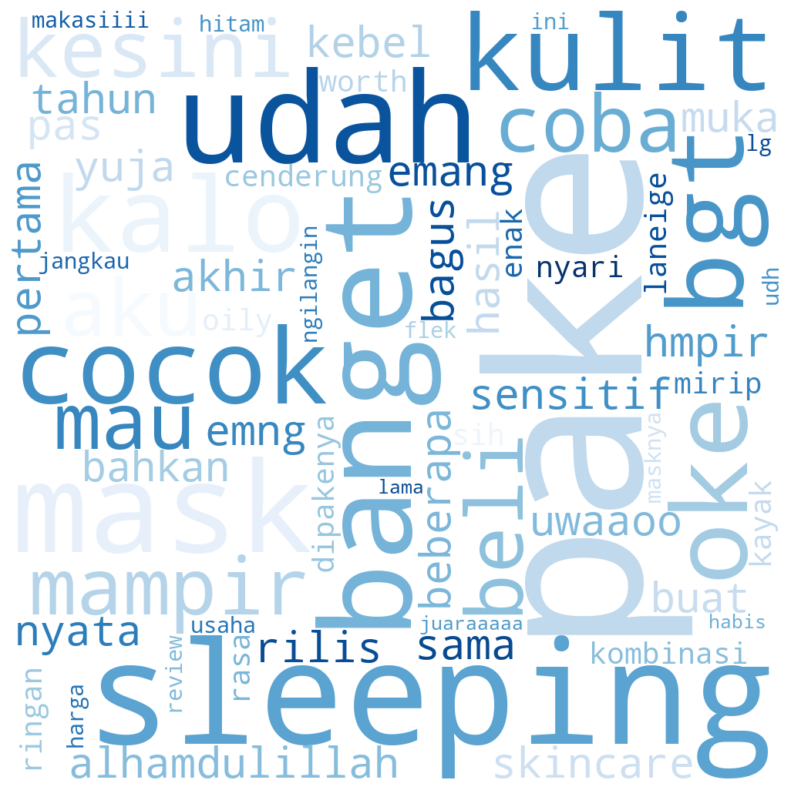

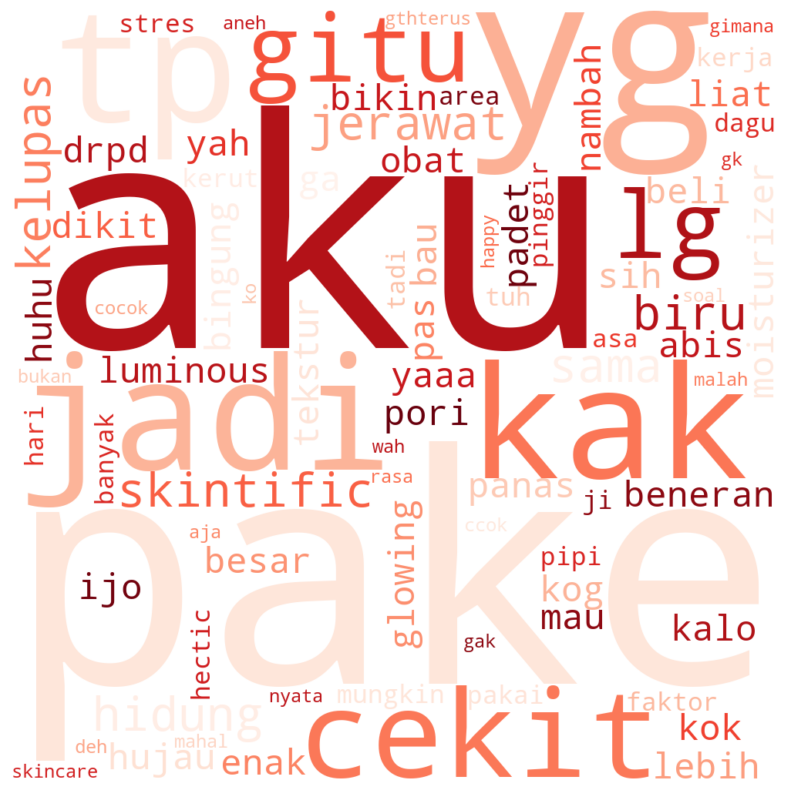

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# polarisasi positif
dataset_negatif = df_comments[df_comments['label'] == 'positif']
dataset_negatif_text = ' '.join(word for word in dataset_negatif['preprocess'])
wc = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(dataset_negatif_text)
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

# polarisasi negatif
dataset_negatif = df_comments[df_comments['label'] == 'negatif']
dataset_negatif_text = ' '.join(word for word in dataset_negatif['preprocess'])
wc = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(dataset_negatif_text)
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

#### Bagi dataset menjadi 80% data training dan 20% data testing

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_comments['preprocess'], df_comments['label'], test_size=0.2, stratify=df_comments['label'], random_state=0)

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df_comments['preprocess'])

terms = vectorizer.get_feature_names_out()

idf_values = vectorizer.idf_

tfidf_df = pd.DataFrame(X.toarray().T, index=terms, columns=[f'D{i+1}' for i in range(len(df_comments['preprocess']))])

idf_df = pd.DataFrame(idf_values, index=terms, columns=["IDF"])

def compute_tf(doc):
    words = doc.split()
    count = Counter(words)
    total_terms = len(words)
    tf = {term: count[term] / total_terms for term in count}
    return tf

tf_dicts = [compute_tf(doc) for doc in df_comments['preprocess']]
tf_df = pd.DataFrame(tf_dicts, index=[f'D{i+1}' for i in range(len(df_comments['preprocess']))]).T

# Fill NaN values with 0
tf_df = tf_df.fillna(0)
idf_df = idf_df.fillna(0)
tfidf_df = tfidf_df.fillna(0)

# # Display DataFrames
print("Term Frequency (TF):")
print(tf_df)
print("\nInverse Document Frequency (IDF):")
print(idf_df)
print("\nTF-IDF Matrix:")
print(tfidf_df)



Term Frequency (TF):
          D1   D2   D3   D4   D5   D6   D7        D8        D9       D10
aku     0.05  0.0  0.0  0.0  0.0  0.0  0.0  0.046512  0.041667  0.086957
mampir  0.05  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000
kesini  0.05  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000
mau     0.05  0.0  0.0  0.0  0.0  0.0  0.0  0.023256  0.000000  0.000000
coba    0.05  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000
...      ...  ...  ...  ...  ...  ...  ...       ...       ...       ...
ko      0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.043478
mahal   0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.043478
malah   0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.043478
gk      0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.043478
ccok    0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.043478

[136 rows x 10 columns]

Inverse Document Frequency (IDF):
                    IDF
abis           2.70

In [7]:
# run once
# Vektor Hasil tranformasi term data testing dengan data training
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

print(X_train.toarray())
print(X_test.toarray())

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.65147471 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.27299333 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.32573736 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.32573736 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.14540433 0.32573736 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.   

#### Prediksi Kelas Dataset

In [8]:
# Tampilkan hasil prediksi data test
from sklearn.svm import SVC

model = SVC(random_state=0, kernel='rbf')

model.fit(X_train, y_train)
predict = model.predict(X_test)
print(predict)


['positif' 'negatif']


#### Hitung Akurasi

In [9]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# f1-score
print('F1-Score : ', f1_score(y_test, predict, pos_label='positif'))
# Accuracy
print('Accuracy : ', accuracy_score(y_test, predict))
# precision
print('Precision : ', precision_score(y_test, predict, pos_label='positif'))
# recall
print('Recall : ', recall_score(y_test, predict, pos_label='positif'))


# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
tn, fp, fn, tp


F1-Score :  0.0
Accuracy :  0.0
Precision :  0.0
Recall :  0.0


(np.int64(0), np.int64(1), np.int64(1), np.int64(0))